# Notebook 2b - Hit detection
Chemical screen, single plate at 750 cells per well.  
In this notebook, we start from the image-level profiles generated in Notebook 2a and identify morphological hits (compounds inducing significant morphological changes compared to DMSO controls), assessed by the robust Hellinger distance.

In [1]:
using CSV, StatsBase, Statistics, DataFrames, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed
using ParallelDataTransfer
using BioProfiling, UMAP

In [2]:
using Dates: now
now()

2021-05-07T18:26:26.668

In [3]:
# Set the number of processes to use for parallel computing
addprocs(16)
pool = CachingPool(workers())

CachingPool(Channel{Int64}(sz_max:9223372036854775807,sz_curr:16), Set([2, 16, 11, 7, 9, 10, 17, 8, 6, 4, 3, 5, 13, 14, 15, 12]), IdDict{Tuple{Int64,Function},RemoteChannel}())

## R Calls

In [4]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [5]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import("/tmp/.fonts")
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Registering fonts with R
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Load measurements

### Load annotations

In [6]:
annotations = CSV.read("data/transferList.txt", DataFrame, header = 1, delim = "\t")
# Convert plate number to strings to make clear it is an ID and should not be used for computations
annotations[!,:DestinationPlate] = string.(annotations[:,:DestinationPlate])
# Wells in the transfer list without any compound name are filled with DMSO only
annotations[!,:CompoundName][ismissing.(annotations[:,:CompoundName])] .= "DMSO"
# A non-ASCII characters needs to be converted
annotations.CompoundName = replace.(annotations.CompoundName, "\xb1" => s"±");

In [7]:
annotations

,DestWell,SourcePlate_A,SrcWell_A,DestinationPlate,Type_A,VolumeTransferred_A
,String,String,String,String,String,Int64
1,A01,CLOMP_D4,M04,1914001,Cpd,100
2,A02,CLOUD10mM10,I19,1914001,Cpd,100
3,A03,CLOUD10mM10,A10,1914001,Cpd,100
4,A04,CLOMP002a,L04,1914001,Cpd,100
5,A05,CLOUD10mM10,I05,1914001,Cpd,100
6,A06,CLOMP002a,B11,1914001,Cpd,100
7,A07,CLOMP001a,F15,1914001,Cpd,10
8,A08,CLOMP003a,I20,1914001,Cpd,100
9,A09,CLOUD10mM10,M19,1914001,Cpd,100


### Load image data

In [8]:
image = CSV.read("data/compiled_PilotDrugScreen_Image_750.csv", DataFrame)
println(string.(names(image))[1:8])
# Number of images and features available
println(nrow(image))
println(ncol(image))

["Column1", "AreaOccupied_AreaOccupied_CytoCM", "AreaOccupied_AreaOccupied_Cytoplasm", "AreaOccupied_AreaOccupied_Nucleus", "AreaOccupied_Perimeter_CytoCM", "AreaOccupied_Perimeter_Cytoplasm", "AreaOccupied_Perimeter_Nucleus", "AreaOccupied_TotalArea_CytoCM"]
7680
1916


## Coarse-grain aggregation

In [9]:
aggregatedData = CSV.read("data/aggregatedData_750cells_noSparse.csv", DataFrame);

### Transform aggregated data - Normalization
We want to focus on variables that are changing more overall than inside of reference condition (untreated WT).

In [10]:
expAgg = Experiment(aggregatedData, description = "Median values for aggregated FOV measurements")

"Experiment with 6622/6622 entries and 390/390 features selected."

In [11]:
filters = Array{BioProfiling.AbstractSelector,1}()
# Remove metadata
strToRemove = ["Metadata_Well", "CompoundName", "Metadata_Field", "Metadata_Row", "Metadata_Column"]
push!(filters, NameSelector(x -> !any(occursin.(strToRemove, String(x)))))
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"))
select_features!(expAgg, filters)

In [12]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [13]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selected_features] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
    expTransformed.data[i:i, expTransformed.selected_features] ./= 
        mapcols(mad, ndf[(c1 .& (c2 .| c3)),:]) 
end

select_features!(expTransformed,
                 Selector(x -> !any(isinf.(x)), 
                        description = "Remove features with infinite values " *
                            "(i.e. with no variation for a subset of the DMSO images)"));

decorrelate_by_mad!(expTransformed);

## Visualization

In [14]:
using Distances

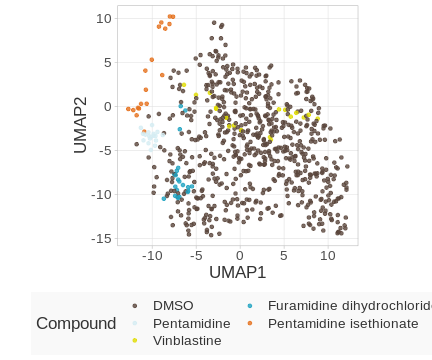

RObject{VecSxp}


In [15]:
Random.seed!(3895)
umTPM = umap(expTransformed, metric = CosineDist(), min_dist = 2)
umTPM = convert(DataFrame, umTPM')
rename!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "Furamidine", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

## Distance to DMSO

### UMAP-based distance

In [16]:
Random.seed!(3895)
umTPM = umap(expTransformed, 4, metric = CosineDist(), min_dist = 2)
umTPM = convert(DataFrame, umTPM')
rename!(umTPM, [:UMAP1, :UMAP2, :UMAP3, :UMAP4])
umTPM.Compound = aggregatedData.CompoundName;

In [17]:
expUMAP = Experiment(umTPM, description = "UMAP projection of profiling data")

"Experiment with 6622/6622 entries and 5/5 features selected."

In [18]:
filters = Array{BioProfiling.AbstractReduce,1}()
# Remove (categorical) compound column from analysis
push!(filters, NameSelector(x -> x != "Compound"))
# Remove entries for compounds not present often enough
cmpd_to_keep = levels(umTPM.Compound)[freqtable(umTPM.Compound) .>= 8]
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y))
push!(filters, Filter(cmpd_to_keep, :Compound, compare = compare_in))
# Apply filters
filter!(expUMAP, filters)
expUMAP

"Experiment with 6549/6622 entries and 4/5 features selected."

NB: because the `compare` function of Filter `f` is applied as f.compare.(entries, f.value)
the value provided needs to be of the length of the entries or of length 1.  
Otherwise, when broadcasting (calling `f.compare` on all elements with `f.compare.`), we need to specify that the `f.value` should be used "as is". This is done by overloading the broadcasting of the function. See:   
https://discourse.julialang.org/t/how-to-broadcast-over-only-certain-function-arguments/19274/5  
Another "trick" is to use a function that takes a length 1 value that is in practice not used:  
```julia
push!(filters, Filter("NotUsed", :Compound, compare = (x,y) -> (x in cmpd_to_keep)))
```

In [19]:
# The following RMD values are displayed in the following order:
selectedCompounds = expUMAP.data[expUMAP.selected_entries, :Compound]
levels(selectedCompounds)

278-element Array{String,1}:
 "(+)-Butaclamol hydrochloride"
 "(+)-Cyclazocine"
 "(+/-)-Sulfinpyrazone"
 "(-)-JQ1"
 "(-)-Perillic acid"
 "(-)-Quinpirole hydrochloride"
 "(-)-trans-(1S,2S)-U-50488 hydrochloride"
 "(S)-Propranolol hydrochloride"
 "(±)-Isoproterenol hydrochloride"
 "(±)-Methoxyverapamil hydrochloride"
 "(±)-Metoprolol (+)-tartrate"
 "(±)-Octoclothepin maleate"
 "(±)-SKF-38393 hydrochloride"
 ⋮
 "U-62066"
 "U0126"
 "UNC0379 trifluoroacetate salt"
 "Vinblastine"
 "Vincristine sulfate"
 "WIN 62,577"
 "WZ4003"
 "Wiskostatin"
 "XL388"
 "Y-27632 dihydrochloride"
 "Yoda1"
 "alpha-Lobeline hydrochloride"

### Compute robust morphological perturbation value (RMPV)

Note: with previous versions of Julia, pmap was slower than using SharedArrays and a `@sync @distributed for` loops. This is not the case for Julia 1.5, so we use pmap for the sake of readability.

In [20]:
now()

2021-05-07T18:31:22.572

Takes ~1h20mn with 16 cores

In [21]:
@everywhere using BioProfiling
plateRMPV = robust_morphological_perturbation_value(expUMAP, :Compound, "DMSO"; 
    nb_rep = 5000, dist = :RobHellinger, process_pool = pool)

┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: robustbase
└ @ RCall /opt/julia/packages/

,RMPV,Distance,Condition
,Float64,Float64,String
1,0.247918,0.462109,(+)-Butaclamol hydrochloride
2,0.0288018,0.628212,(+)-Cyclazocine
3,0.00191724,0.74496,(+/-)-Sulfinpyrazone
4,0.000368212,0.769655,(-)-JQ1
5,0.157001,0.518261,(-)-Perillic acid
6,0.00161628,0.726586,(-)-Quinpirole hydrochloride
7,0.00870505,0.678042,"(-)-trans-(1S,2S)-U-50488 hydrochloride"
8,0.0286805,0.623367,(S)-Propranolol hydrochloride
9,0.0,0.945019,(±)-Isoproterenol hydrochloride


In [22]:
now()

2021-05-07T19:53:54.681

In [23]:
# Missing values might need to be handled
@assert !any(ismissing.(plateRMPV.RMPV))

In [24]:
# Export to avoid recomputing if not necessary
CSV.write("data/RMPV.csv", plateRMPV);

In [25]:
plateRMPV = CSV.read("data/RMPV.csv", DataFrame)

,RMPV,Distance,Condition
,Float64,Float64,String
1,0.247918,0.462109,(+)-Butaclamol hydrochloride
2,0.0288018,0.628212,(+)-Cyclazocine
3,0.00191724,0.74496,(+/-)-Sulfinpyrazone
4,0.000368212,0.769655,(-)-JQ1
5,0.157001,0.518261,(-)-Perillic acid
6,0.00161628,0.726586,(-)-Quinpirole hydrochloride
7,0.00870505,0.678042,"(-)-trans-(1S,2S)-U-50488 hydrochloride"
8,0.0286805,0.623367,(S)-Propranolol hydrochloride
9,0.0,0.945019,(±)-Isoproterenol hydrochloride


In [26]:
cpd_to_label = ["DMSO", "Vinblastine", "Pentamidine", "Wiskostatin", 
     "Gefitinib", "Imatinib", "Hydroxychloroquine"]
plateRMPV.Label = [x in cpd_to_label ? x : "" for x in plateRMPV.Condition];

RObject{VecSxp}


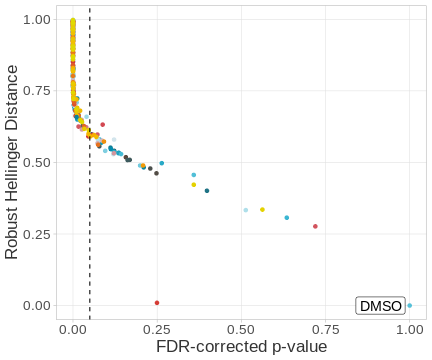

┌ Warning: RCall.jl: Warning: ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


In [27]:
# Display number of positive tests
gp = ggplot(plateRMPV, aes(x = :RMPV, y = :Distance)) + geom_point(aes(color = :Condition)) + 
    geom_vline(xintercept = 0.05, linetype = "dashed") +
    geom_label_repel(aes(label = :Label), size = 5) + 
    guides(color = false) +
    xlab("FDR-corrected p-value") +
    ylab("Robust Hellinger Distance") +
    RObject(nothing)
print(gp);

In [28]:
ggsave("fig/UMAP_RMPV_test_hellinger_annotated.pdf", gp);

LoadError: REvalError: Saving 7 x 7 in image
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning: ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Error in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  : 
  invalid font type
Calls: <Anonymous> ... drawDetails -> drawDetails.text -> grid.Call.graphics

With this method, we find 232 strong hits (FDR .05) or 248 (FDR .1).

In [29]:
println.(plateRMPV[plateRMPV.RMPV .< 0.1,:Condition]);

(+)-Cyclazocine
(+/-)-Sulfinpyrazone
(-)-JQ1
(-)-Quinpirole hydrochloride
(-)-trans-(1S,2S)-U-50488 hydrochloride
(S)-Propranolol hydrochloride
(±)-Isoproterenol hydrochloride
(±)-Methoxyverapamil hydrochloride
(±)-Metoprolol (+)-tartrate
(±)-Octoclothepin maleate
(±)-SKF-38393 hydrochloride
1,10-Phenanthroline monohydrate
1,7-Dimethylxanthine
2,2'-Bipyridyl
2,3-Dimethoxy-1,4-naphthoquinone
2-methoxyestradiol
4-(2-Aminoethyl)benzenesulfonyl fluoride hydrochloride
4-Hydroxy-3-methoxyphenylacetic acid
5-(N,N-hexamethylene)amiloride
5-(N-Ethyl-N-isopropyl)amiloride
5-Bromo-2'-deoxyuridine
5-Fluorouracil
5-azacytidine
5alpha-Pregnan-3alpha-ol-20-one
6,7-ADTN hydrobromide
6-Nitroso-1,2-benzopyrone
7-Cyclopentyl-5-(4-phenoxy)phenyl-7H-pyrrolo[2,3-d]pyrimidin-4-ylamine
AC-93253 iodide
AEG 3482
AMG 9810
Albendazole
Aliskiren
Amodiaquine
Ancitabine hydrochloride
Apomorphine hydrochloride hemihydrate
Arbidol hydrochloride
Aurothioglucose
BIO
BRD3308
BTO-1
BW 723C86
Benidipine hydrochloride
Benox

In [30]:
println.(plateRMPV[plateRMPV.RMPV .< 0.05,:Condition]);

(+)-Cyclazocine
(+/-)-Sulfinpyrazone
(-)-JQ1
(-)-Quinpirole hydrochloride
(-)-trans-(1S,2S)-U-50488 hydrochloride
(S)-Propranolol hydrochloride
(±)-Isoproterenol hydrochloride
(±)-Methoxyverapamil hydrochloride
(±)-Octoclothepin maleate
(±)-SKF-38393 hydrochloride
1,10-Phenanthroline monohydrate
2,2'-Bipyridyl
2,3-Dimethoxy-1,4-naphthoquinone
2-methoxyestradiol
4-(2-Aminoethyl)benzenesulfonyl fluoride hydrochloride
4-Hydroxy-3-methoxyphenylacetic acid
5-(N,N-hexamethylene)amiloride
5-(N-Ethyl-N-isopropyl)amiloride
5-Bromo-2'-deoxyuridine
5-Fluorouracil
5-azacytidine
5alpha-Pregnan-3alpha-ol-20-one
6,7-ADTN hydrobromide
6-Nitroso-1,2-benzopyrone
7-Cyclopentyl-5-(4-phenoxy)phenyl-7H-pyrrolo[2,3-d]pyrimidin-4-ylamine
AC-93253 iodide
AEG 3482
AMG 9810
Albendazole
Aliskiren
Amodiaquine
Ancitabine hydrochloride
Apomorphine hydrochloride hemihydrate
Arbidol hydrochloride
Aurothioglucose
BIO
BRD3308
BW 723C86
Benidipine hydrochloride
Benoxathian hydrochloride
Benzamil hydrochloride
Benztropine

## Display tops and flops

In [31]:
plateRMPV.Condition[sortperm(plateRMPV.Distance)[1:10]]

10-element Array{String,1}:
 "DMSO"
 "None"
 "Mitoxantrone"
 "Dantrolene sodium"
 "Histamine, R(-)-alpha-methyl-, dihydrochloride"
 "U-62066"
 "5HPP-33"
 "U-101958 maleate"
 "Dipyridamole"
 "(+)-Butaclamol hydrochloride"

In [32]:
plateRMPV.Condition[sortperm(plateRMPV.Distance)[(end-9):end]]

10-element Array{String,1}:
 "Carmofur"
 "5-(N,N-hexamethylene)amiloride"
 "ML324"
 "Loperamide"
 "Cyclosporin A"
 "Clotrimazole"
 "Diphenyleneiodonium chloride"
 "Ellipticine"
 "WZ4003"
 "Iodoacetamide"

In [33]:
Random.seed!(3895)
umTPM = umap(expTransformed, metric = CosineDist(), min_dist = 2)
umTPM = convert(DataFrame, umTPM')
rename!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName;

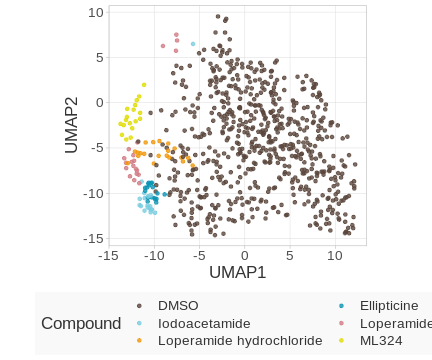

RObject{VecSxp}


In [34]:
subsetCompounds = ["Iodoacetamide", "Ellipticine", "Loperamide", "DMSO", "ML324"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

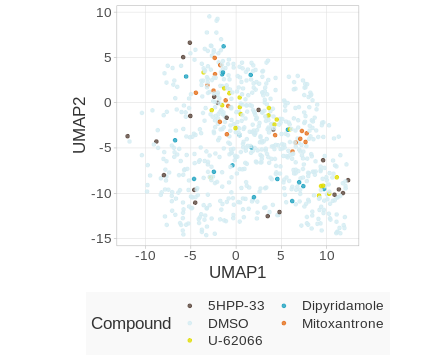

RObject{VecSxp}


In [35]:
subsetCompounds = ["Mitoxantrone", "U-62066", "5HPP-33", "DMSO", "Dipyridamole"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))